In [1]:
import ultralytics
print("YOLOv8 version:", ultralytics.__version__)


YOLOv8 version: 8.3.234


In [2]:
import os
import glob
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil


In [3]:
DATASET_DIR = "Dataset"   
ANNOT_DIR = f"{DATASET_DIR}/annotations"
IMAGE_DIR = f"{DATASET_DIR}/images"


In [4]:
import os
import xml.etree.ElementTree as ET

OUTPUT_DIR = "yolo_dataset"
os.makedirs(f"{OUTPUT_DIR}/images/train", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/images/val", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/labels/val", exist_ok=True)

annotations = glob.glob(os.path.join(ANNOT_DIR, "*.xml"))
images = glob.glob(os.path.join(IMAGE_DIR, "*.png"))

def convert_to_yolo(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    img_path = os.path.join(IMAGE_DIR, image_name)

    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    yolo_data = []
    for obj in root.findall("object"):
        label = obj.find("name").text
        class_id = 0 if label == "with_mask" else 1

        box = obj.find("bndbox")
        xmin = int(box.find("xmin").text)
        ymin = int(box.find("ymin").text)
        xmax = int(box.find("xmax").text)
        ymax = int(box.find("ymax").text)

        x_center = (xmin + xmax) / (2.0 * w)
        y_center = (ymin + ymax) / (2.0 * h)
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h

        yolo_data.append(f"{class_id} {x_center} {y_center} {bw} {bh}")

    label_path = xml_file.replace(".xml", ".txt")
    return image_name, yolo_data, label_path


In [5]:
train_files, val_files = train_test_split(annotations, test_size=0.2, random_state=42)

def process_files(file_list, mode):
    for xml in file_list:
        img_name, yolo_data, _ = convert_to_yolo(xml)

        txt_path = xml.replace(".xml", ".txt")

        # Write label file
        with open(f"{OUTPUT_DIR}/labels/{mode}/{img_name.replace('.png','.txt')}", "w") as f:
            for line in yolo_data:
                f.write(line + "\n")

        shutil.copy(os.path.join(IMAGE_DIR, img_name), 
                    f"{OUTPUT_DIR}/images/{mode}/{img_name}")

process_files(train_files, "train")
process_files(val_files, "val")


In [6]:
yaml_content = """
train: yolo_dataset/images/train
val: yolo_dataset/images/val

nc: 2
names: ["with_mask", "without_mask"]
"""

with open("mask.yaml", "w") as f:
    f.write(yaml_content)


In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # nano model → fastest on CPU

results = model.train(
    data="mask.yaml",
    epochs=3,
    batch=8,
    imgsz=640,
    device="cpu"
)


Ultralytics 8.3.234  Python-3.13.5 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=mask.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=3, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

In [8]:
metrics = model.val()
metrics


Ultralytics 8.3.234  Python-3.13.5 torch-2.9.1+cpu CPU (11th Gen Intel Core i5-1135G7 @ 2.40GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 763.1138.9 MB/s, size: 521.0 KB)
val: Scanning C:\Users\sudai\Documents\New folder\face mask detection\New folder\yolo_dataset\labels\val.cache... 171 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 171/171 100.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.8s/it 30.6s2.8s
                   all        171        754      0.808      0.716      0.793        0.5
             with_mask        159        630       0.93      0.795      0.908      0.596
          without_mask         57        124      0.687      0.637      0.679      0.403
Speed: 1.1ms preprocess, 113.2ms inference, 0.0ms loss, 22.5ms postprocess per image
Results saved to C:\Users\sudai\Documents\New folder\face mask d

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002362CBC2D70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

result = model("yolo_dataset/images/val/0.png", show=True)


In [11]:
import cv2

model = YOLO("runs/detect/train/weights/best.pt")

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    results = model(frame)
    annotated = results[0].plot()
    
    cv2.imshow("Mask Detection", annotated)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




0: 480x640 1 with_mask, 240.4ms
Speed: 5.6ms preprocess, 240.4ms inference, 4.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 90.1ms
Speed: 1.6ms preprocess, 90.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 85.8ms
Speed: 2.1ms preprocess, 85.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 89.7ms
Speed: 1.9ms preprocess, 89.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 95.1ms
Speed: 2.6ms preprocess, 95.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 92.6ms
Speed: 2.8ms preprocess, 92.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 90.8ms
Speed: 2.1ms preprocess, 90.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 with_mask, 98.8ms
Speed: 1.8ms preprocess, 98.8ms inference, 5.9ms postprocess pe

In [28]:
from ultralytics import YOLO
from IPython.display import display
from PIL import Image
from ipywidgets import FileUpload
import io

# Load trained YOLO model
model = YOLO("runs/detect/train/weights/best.pt")  # path to your trained model

# Create upload widget for multiple images
upload_widget = FileUpload(accept='image/*', multiple=True)
display(upload_widget)

print("Upload one or more images using the widget above, then run the next cell to detect masks.")

def detect_mask(upload_widget):
    if len(upload_widget.value) == 0:
        print("No files uploaded yet.")
        return

    # Loop through all uploaded files (tuple)
    for i, file_data in enumerate(upload_widget.value):

        image_bytes = file_data['content']
        original_name = file_data['name']

        # Load image
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Save temporarily
        temp_path = f"temp_image_{i}.png"
        image.save(temp_path)

        # YOLO inference
        results = model(temp_path)

        # Get annotated image
        annotated_image = results[0].plot()
        annotated_pil = Image.fromarray(annotated_image)

        # Display output
        display(annotated_pil)

        # Save output
        base_name = original_name.split('.')[0]
        ext = original_name.split('.')[-1]

        output_path = rf"C:\Users\sudai\Documents\New folder\face mask detection\New folder\{base_name}_annotated.{ext}"
        annotated_pil.save(output_path)

        print(f"Saved → {output_path}")

    print("\nAll images processed successfully!")


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Upload one or more images using the widget above, then run the next cell to detect masks.



image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_0.png: 480x640 2 with_masks, 5 without_masks, 67.7ms
Speed: 3.0ms preprocess, 67.7ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


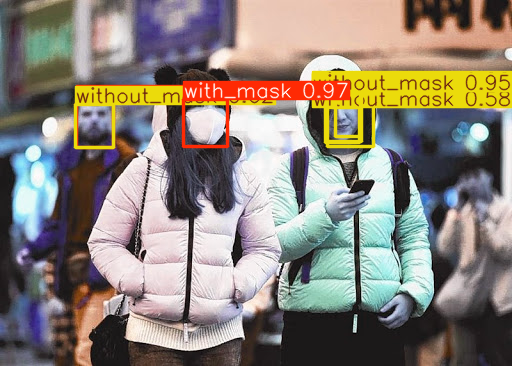

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss0_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_1.png: 256x640 8 with_masks, 1 without_mask, 193.2ms
Speed: 3.6ms preprocess, 193.2ms inference, 4.5ms postprocess per image at shape (1, 3, 256, 640)


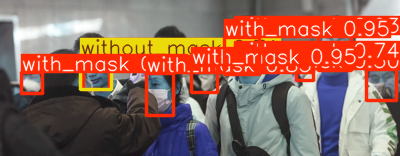

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss1_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_2.png: 480x640 4 with_masks, 1 without_mask, 232.6ms
Speed: 4.8ms preprocess, 232.6ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 640)


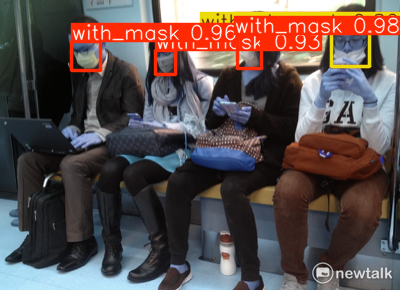

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss2_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_3.png: 448x640 8 with_masks, 208.5ms
Speed: 3.3ms preprocess, 208.5ms inference, 6.6ms postprocess per image at shape (1, 3, 448, 640)


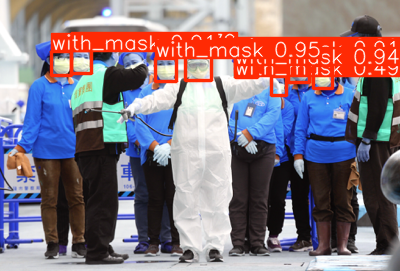

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss3_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_4.png: 640x512 2 with_masks, 220.8ms
Speed: 5.2ms preprocess, 220.8ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 512)


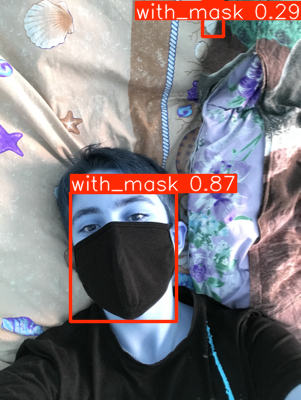

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss4_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_5.png: 448x640 3 with_masks, 4 without_masks, 225.2ms
Speed: 4.9ms preprocess, 225.2ms inference, 4.5ms postprocess per image at shape (1, 3, 448, 640)


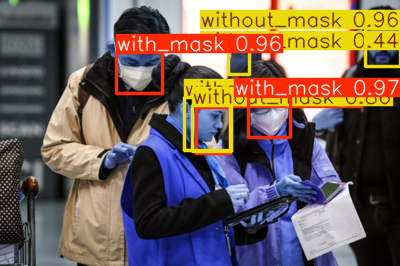

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss5_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_6.png: 448x640 1 with_mask, 319.5ms
Speed: 6.8ms preprocess, 319.5ms inference, 3.9ms postprocess per image at shape (1, 3, 448, 640)


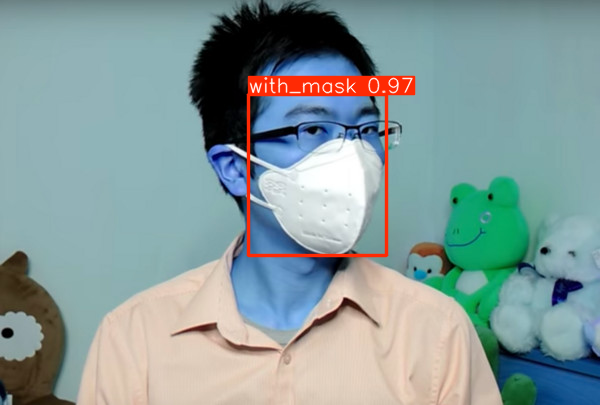

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss6_annotated.png

image 1/1 C:\Users\sudai\Documents\New folder\face mask detection\New folder\temp_image_7.png: 480x640 2 with_masks, 1 without_mask, 109.5ms
Speed: 3.1ms preprocess, 109.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


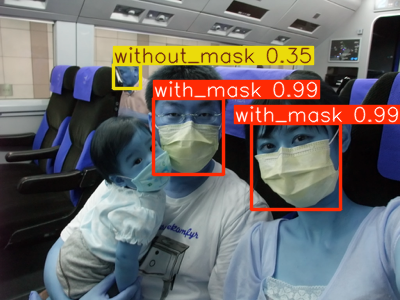

Saved → C:\Users\sudai\Documents\New folder\face mask detection\New folder\maksssksksss7_annotated.png

All images processed successfully!


In [29]:
detect_mask(upload_widget)
